In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import re
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 data = pd.read_csv('Data/PRO_DATASET.csv ')
 data.head()

,Unnamed: 0,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,month,year,month_year,TotalMoney,WeekDay,freq
0,25361,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432.0,United Kingdom,11,2019,2019-11-01,48.32,Saturday,377
1,25362,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432.0,United Kingdom,11,2019,2019-11-01,24.16,Saturday,377
2,25363,579522,2019-11-30,82483,Wood 2 Drawer Cabinet White Finish,6.04,8,14432.0,United Kingdom,11,2019,2019-11-01,48.32,Saturday,377
3,25364,579522,2019-11-30,23493,Vintage Doily Travel Sewing Kit,6.04,10,14432.0,United Kingdom,11,2019,2019-11-01,60.40,Saturday,377
4,25365,579522,2019-11-30,23240,Set Of 4 Knick Knack Tins Doily,6.19,6,14432.0,United Kingdom,11,2019,2019-11-01,37.14,Saturday,377


#**RFM**

In [ ]:
print("Min Date",data['Date'].min(), "Max Date", data['Date'].max())

Min Date 2018-12-01 Max Date 2019-11-30


In [ ]:
presence = dt.datetime(2019, 12, 1)

# Chuyển đổi kiểu dữ liệu của cột 'Date' sang đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])

rfm = data.groupby('CustomerNo').agg({'Date': lambda x: (presence - x.max()).days,
                                      'TransactionNo': lambda x: len(x),
                                      'TotalMoney': lambda x: x.sum()})
rfm['Date'] = rfm['Date'].astype(int)
rfm.rename(columns={'Date': 'recency',
                   'TransactionNo': 'frequency',
                   'TotalMoney': 'monetary_value'}, inplace=True)

In [ ]:
rfm = data.groupby('CustomerNo').agg({'Date': lambda date: (presence - date.max()).days,
                                    'TransactionNo': lambda inv: inv.nunique(),
                                    'TotalMoney': lambda price: price.sum()})
rfm = rfm.rename(columns = {'Date': 'Recency',
                            'TransactionNo': 'Frequency',
                            'TotalMoney': 'Monetary'
})
rfm.sort_values(by='Frequency', ascending=False).head()

,Recency,Frequency,Monetary
CustomerNo,,,
12748.0,2,198,262134.30
14911.0,1,189,889195.17
17841.0,2,121,243080.24
13089.0,3,94,339595.04
15311.0,2,88,388148.18


In [ ]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4671.0,95.355170,100.121241,1.00,17.000,52.00,154.00,365.00
Frequency,4671.0,4.061657,7.121585,1.00,1.000,2.00,4.00,198.00
Monetary,4671.0,12902.854853,51618.690375,5.97,1824.365,4742.46,11709.32,2061832.51


# **CHECK OUTLIER**

In [ ]:
features = ['Recency', 'Frequency', 'Monetary']
def plotBoxplot(feats, df):
  fig, axs = plt.subplots(1, 3)
  i = 0
  for i in range(3):
    plt.rcParams['figure.figsize'] = [18, 8]
    axs[i].boxplot(df[feats[i]])
    axs[i].set_title('Distribution of '+ feats[i])
    i +=1
  plt.show()

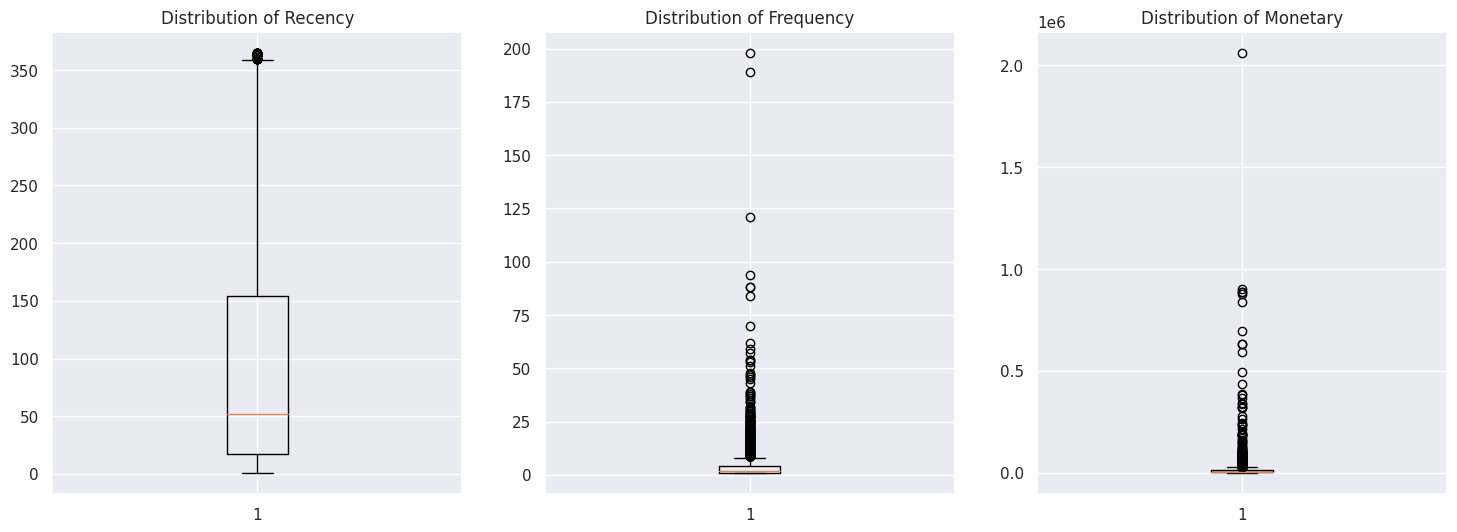

In [ ]:
plotBoxplot(features, rfm)

**SCALE DTA**

In [ ]:
#check if data is skewed
from scipy import stats #library
def check_skew(rfm, column):
    skew = stats.skew(rfm[column])
    skewtest = stats.skewtest(rfm[column])
    # plt.figure(figsize=(12, ))
    plt.figure(figsize=(12,8)); sns.distplot(rfm[column])
    plt.title('Distribution of ' + column)
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from scipy import stats

def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(8,8))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(((rfm[x])**(1/3)), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

    print('Skew: ', rfm[x].skew().round(2))
    print('Log: ', np.log(rfm[x]).skew().round(2))
    print('Sqrt', ((rfm[x])**(1/3)).skew().round(2))
    print('Boxcox', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))
    print('Zscore', stats.zscore(rfm[x]).skew().round(2))

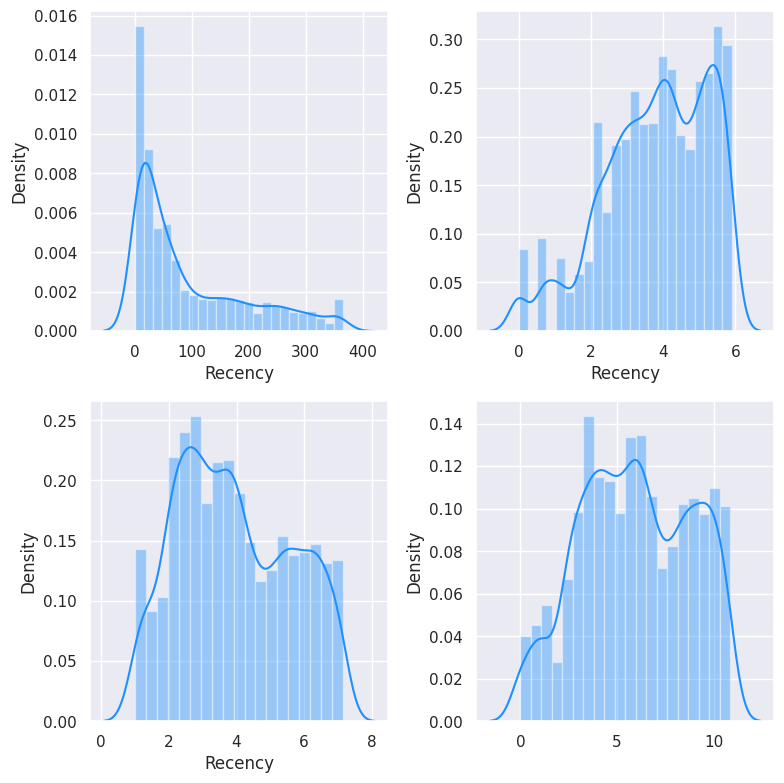

Skew:  1.14
Log:  -0.58
Sqrt 0.22
Boxcox -0.08
Zscore 1.14


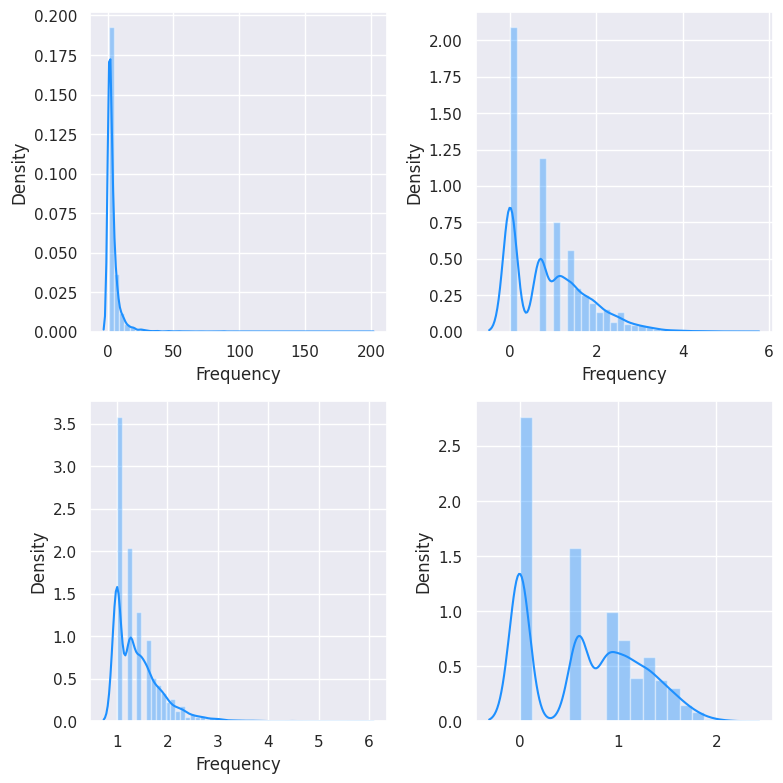

Skew:  12.19
Log:  0.79
Sqrt 1.92
Boxcox 0.14
Zscore 12.19


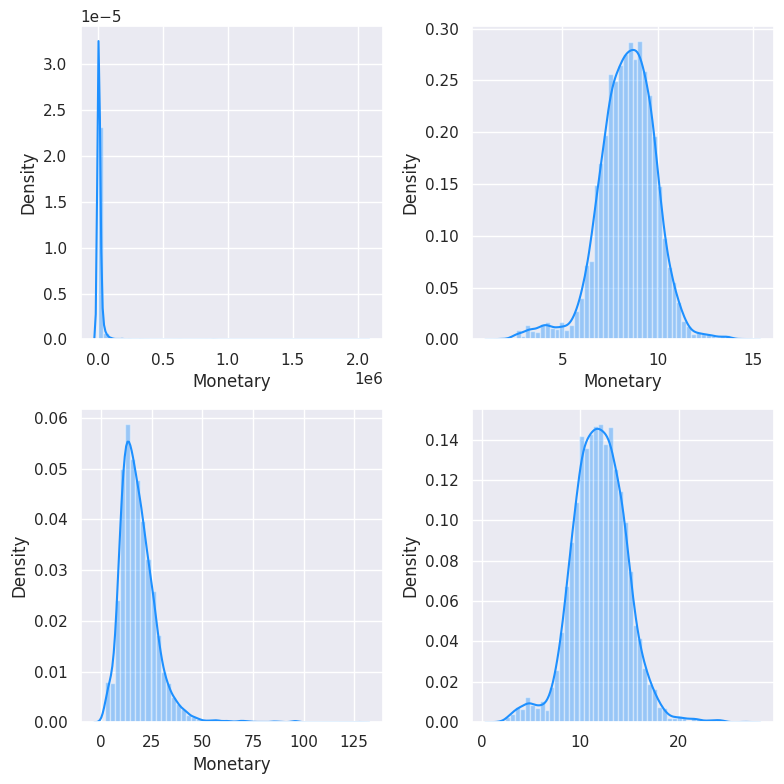

Skew:  21.04
Log:  -0.51
Sqrt 2.4
Boxcox 0.05
Zscore 21.04


In [ ]:
sns.set_palette(['#1E90FF'])
analyze_skewness('Recency')
analyze_skewness('Frequency')
analyze_skewness('Monetary')

In [ ]:
#Tranform
df_rfm = pd.DataFrame()

df_rfm['Recency'] = stats.boxcox(rfm['Recency'])[0]
df_rfm['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
df_rfm['Monetary'] = stats.boxcox(rfm['Monetary'])[0]
df_rfm.head()

,Recency,Frequency,Monetary
0,9.349758,0.0,9.815378
1,9.234240,0.0,3.638082
2,9.918553,0.0,12.261906
3,10.713192,0.0,5.020491
4,8.635101,0.0,6.103261


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_rfm)

df_rfm = scaler.transform(df_rfm)

In [ ]:
pd.DataFrame(df_rfm).head()

,0,1,2
0,1.200123,-1.184401,-0.757281
1,1.159361,-1.184401,-2.985388
2,1.400830,-1.184401,0.125164
3,1.681229,-1.184401,-2.486763
4,0.947946,-1.184401,-2.096215


# **K-MEANS**

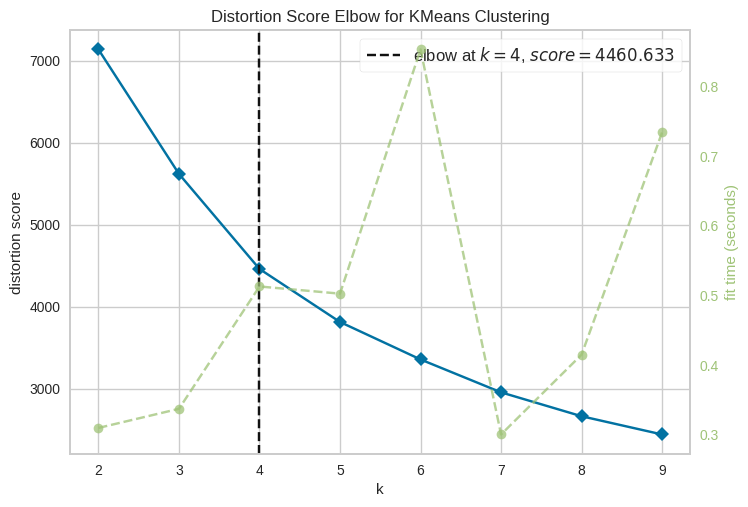

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

k_means = KMeans(random_state=1)
elbow = KElbowVisualizer(k_means, k=(2, 10))
elbow.fit(df_rfm)
elbow.show()

In [ ]:
model = KMeans(n_clusters=elbow.elbow_value_)
model.fit(df_rfm)

KMeans(n_clusters=4)

In [ ]:
# df_rfm['Cluster'] = model.labels_
# pd.DataFrame(df_rfm)
rfm['Cluster'] = model.labels_
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4671.0,95.355170,100.121241,1.00,17.000,52.00,154.00,365.00
Frequency,4671.0,4.061657,7.121585,1.00,1.000,2.00,4.00,198.00
Monetary,4671.0,12902.854853,51618.690375,5.97,1824.365,4742.46,11709.32,2061832.51
Cluster,4671.0,1.389210,1.090588,0.00,0.000,1.00,2.00,3.00


In [ ]:
rfm

,Recency,Frequency,Monetary,Cluster
CustomerNo,,,,
12004.0,219,1,1509.60,1
12006.0,210,1,24.76,1
12008.0,268,1,5689.57,1
12013.0,351,1,69.96,1
12024.0,168,1,149.52,1
...,...,...,...,...
18280.0,269,1,623.26,1
18281.0,172,1,576.58,1
18282.0,118,1,871.54,1


In [ ]:
# rfm.to_csv('/content/drive/Shareddrives/[ML - THẦY THÀNH]/PROJECT/2. DATA/RFM_DATASET.csv ')

In [ ]:
test = pd.DataFrame(rfm['Cluster'].value_counts())
test['Per'] = (test['Cluster']/len(rfm.axes[0])).round(2)
test = test.rename(columns={'Cluster':'Number of Customers'})
test

,Number of Customers,Per
0,1276,0.27
1,1247,0.27
2,1202,0.26
3,946,0.20


In [ ]:
rfm.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,98.25,3.34,9588.30
1,219.78,1.14,2198.20
2,15.91,9.80,35135.62
3,27.40,1.58,3130.69


In [ ]:
rfm[rfm['Cluster']==0].describe()

,Recency,Frequency,Monetary,Cluster
count,1263.000000,1263.000000,1263.000000,1263.0
mean,98.245447,3.336500,9588.300435,0.0
std,65.424179,1.711337,25333.895460,0.0
min,15.000000,1.000000,264.510000,0.0
25%,51.000000,2.000000,4186.470000,0.0
50%,77.000000,3.000000,6707.540000,0.0
75%,135.500000,4.000000,11037.735000,0.0
max,364.000000,34.000000,840113.800000,0.0


In [ ]:
rfm[rfm['Cluster']==1].describe()

,Recency,Frequency,Monetary,Cluster
count,1257.000000,1257.000000,1257.000000,1257.0
mean,219.782816,1.142403,2198.202673,1.0
std,86.278230,0.358595,2817.313844,0.0
min,42.000000,1.000000,5.970000,1.0
25%,153.000000,1.000000,717.540000,1.0
50%,225.000000,1.000000,1423.440000,1.0
75%,288.000000,1.000000,2566.920000,1.0
max,365.000000,3.000000,29038.070000,1.0


In [ ]:
rfm[rfm['Cluster']==2].describe()

,Recency,Frequency,Monetary,Cluster
count,1208.000000,1208.000000,1.208000e+03,1208.0
mean,15.908940,9.795530,3.513562e+04,2.0
std,14.444706,12.060689,9.446367e+04,0.0
min,1.000000,1.000000,1.657980e+03,2.0
25%,6.000000,5.000000,1.036356e+04,2.0
50%,13.000000,7.000000,1.732351e+04,2.0
75%,21.250000,11.000000,3.062732e+04,2.0
max,118.000000,198.000000,2.061833e+06,2.0


In [ ]:
rfm[rfm['Cluster']==3].describe()

,Recency,Frequency,Monetary,Cluster
count,943.000000,943.000000,943.000000,943.0
mean,27.396607,1.579003,3130.686140,3.0
std,19.514752,0.740018,2846.608978,0.0
min,1.000000,1.000000,12.860000,3.0
25%,11.000000,1.000000,1373.450000,3.0
50%,23.000000,1.000000,2361.360000,3.0
75%,42.000000,2.000000,3917.965000,3.0
max,81.000000,7.000000,33893.720000,3.0


# **Evaluation metrics**

**Silhouette Method to Indentify Clusters**

In [ ]:
import sklearn.metrics as metrics

In [ ]:
rfm = rfm.drop(columns=['Color'])
rfm

,Recency,Frequency,Monetary,Cluster
CustomerNo,,,,
12004.0,219,1,1509.60,1
12006.0,210,1,24.76,1
12008.0,268,1,5689.57,1
12013.0,351,1,69.96,1
12024.0,168,1,149.52,1
...,...,...,...,...
18280.0,269,1,623.26,1
18281.0,172,1,576.58,1
18282.0,118,1,871.54,1


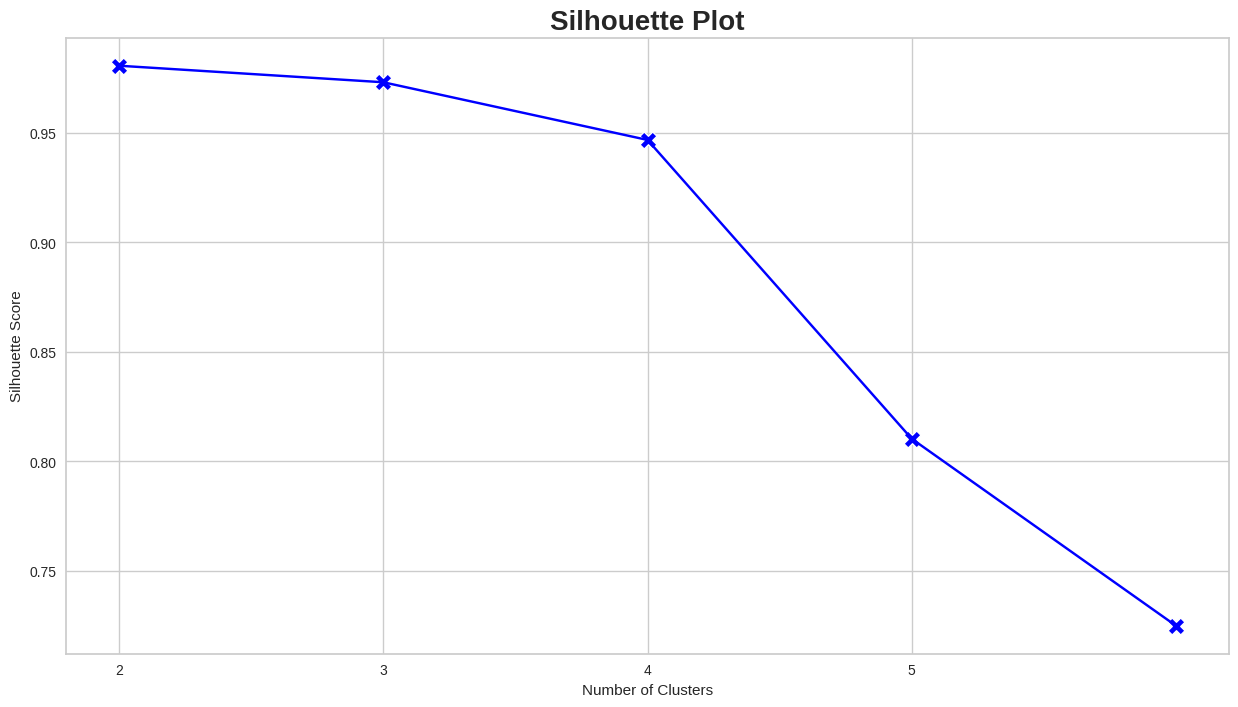

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
candidates = [i for i in range(2,7)]
sc = []

for n_clusters in candidates:
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(rfm)
    del km
    score = silhouette_score(rfm, km_labels)
    sc.append(score)

#creating a dataframe for the sum of silhouette score
df_sc = pd.DataFrame({'Number of Clusters': candidates, 'Silhouette Score': sc})

#plotting sum of squared error results
plt.figure(figsize = (15, 8))
sns.lineplot(data = df_sc, x = 'Number of Clusters', y = 'Silhouette Score', color='blue')
sns.scatterplot(data = df_sc, x = 'Number of Clusters', y = 'Silhouette Score', marker = 'X', s = 150,color='blue')

#customizing
plt.xticks([2,3,4,5])
plt.title('Silhouette Plot', fontweight='bold', fontsize=20)
plt.show()

In [ ]:
# SK = range(2,10)
# sil_score = []
# for i in SK:
#     labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=100).fit(rfm).labels_
#     score = metrics.silhouette_score(rfm,labels,metric="euclidean",sample_size=1000,random_state=100)
#     sil_score.append(score)
#     print ("Silhouette score for k(clusters) = "+str(i)+" is "
#            +str(metrics.silhouette_score(rfm,labels,metric="euclidean",sample_size=1000,random_state=100)))
#answer
from sklearn.metrics import silhouette_samples, silhouette_score
candidates = [i for i in range(2,11)]
sc = []
for n_clusters in candidates:
    km = KMeans(n_clusters=n_clusters, random_state=300)
    # km =  MiniBatchKMeans(n_clusters, random_state=42)
    km_labels = km.fit_predict(rfm)
    del km
    score = silhouette_score(rfm, km_labels)
    print('For n_clusters =', n_clusters,'The average silhouette score is :',round(score,5))

ValueError: ignored

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Tính toán RFM để có được dữ liệu đầu vào cho K-means
# X là ma trận chứa các giá trị Recency, Frequency, Monetary của khách hàng
# ...

# Khởi tạo danh sách các số lượng cụm cần thử
n_clusters_list = [2, 3, 4, 5, 6]

# Lưu giá trị ARI của mỗi số lượng cụm
ari_scores = []

# Lặp qua từng số lượng cụm
for n_clusters in n_clusters_list:
    # Tạo mô hình K-means với số lượng cụm hiện tại
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    # Dự đoán nhãn của các điểm dữ liệu
    labels = kmeans.labels_

    # Tính giá trị ARI giữa nhãn dự đoán và nhãn đúng (nếu có)
    ari = adjusted_rand_score(ground_truth_labels, labels)

    # Lưu giá trị ARI vào danh sách
    ari_scores.append(ari)

# Lựa chọn số lượng cụm tối ưu dựa trên giá trị ARI cao nhất
optimal_n_clusters = n_clusters_list[np.argmax(ari_scores)]

print("Số lượng cụm tối ưu: ", optimal_n_clusters)


In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4671 entries, 12004.0 to 18287.0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4671 non-null   int64  
 1   Frequency  4671 non-null   int64  
 2   Monetary   4671 non-null   float64
 3   Cluster    4671 non-null   int32  
 4   segt_name  4671 non-null   object 
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 200.7+ KB


# VISUALLIZATION

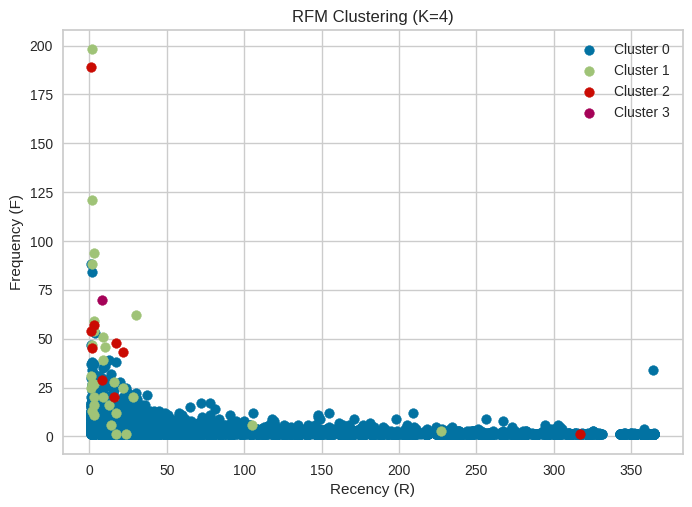

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Tạo dataframe chứa dữ liệu RFM
# Assume rfm_df là dataframe chứa dữ liệu RFM của khách hàng, với cột RFM là kết quả đã tính toán từ RFM analysis
rfm_df = rfm.copy()

# Áp dụng K-means với k=4
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=200)
kmeans.fit(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_df['Cluster'] = kmeans.labels_

# Biểu đồ phân tán
plt.scatter(rfm_df[rfm_df['Cluster'] == 0]['Recency'], rfm_df[rfm_df['Cluster'] == 0]['Frequency'], label='Cluster 0')
plt.scatter(rfm_df[rfm_df['Cluster'] == 1]['Recency'], rfm_df[rfm_df['Cluster'] == 1]['Frequency'], label='Cluster 1')
plt.scatter(rfm_df[rfm_df['Cluster'] == 2]['Recency'], rfm_df[rfm_df['Cluster'] == 2]['Frequency'], label='Cluster 2')
plt.scatter(rfm_df[rfm_df['Cluster'] == 3]['Recency'], rfm_df[rfm_df['Cluster'] == 3]['Frequency'], label='Cluster 3')
plt.xlabel('Recency (R)')
plt.ylabel('Frequency (F)')
plt.title('RFM Clustering (K=4)')
plt.legend()
plt.show()


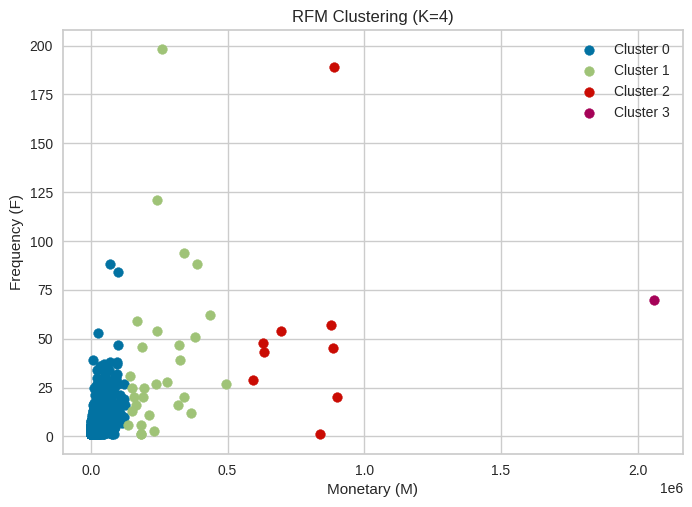

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Tạo dataframe chứa dữ liệu RFM
# Assume rfm_df là dataframe chứa dữ liệu RFM của khách hàng, với cột RFM là kết quả đã tính toán từ RFM analysis
rfm_df = rfm.copy()

# Áp dụng K-means với k=4
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=200)
kmeans.fit(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_df['Cluster'] = kmeans.labels_

# Biểu đồ phân tán
plt.scatter(rfm_df[rfm_df['Cluster'] == 0]['Monetary'], rfm_df[rfm_df['Cluster'] == 0]['Frequency'], label='Cluster 0')
plt.scatter(rfm_df[rfm_df['Cluster'] == 1]['Monetary'], rfm_df[rfm_df['Cluster'] == 1]['Frequency'], label='Cluster 1')
plt.scatter(rfm_df[rfm_df['Cluster'] == 2]['Monetary'], rfm_df[rfm_df['Cluster'] == 2]['Frequency'], label='Cluster 2')
plt.scatter(rfm_df[rfm_df['Cluster'] == 3]['Monetary'], rfm_df[rfm_df['Cluster'] == 3]['Frequency'], label='Cluster 3')
plt.xlabel('Monetary (M)')
plt.ylabel('Frequency (F)')
plt.title('RFM Clustering (K=4)')
plt.legend()
plt.show()


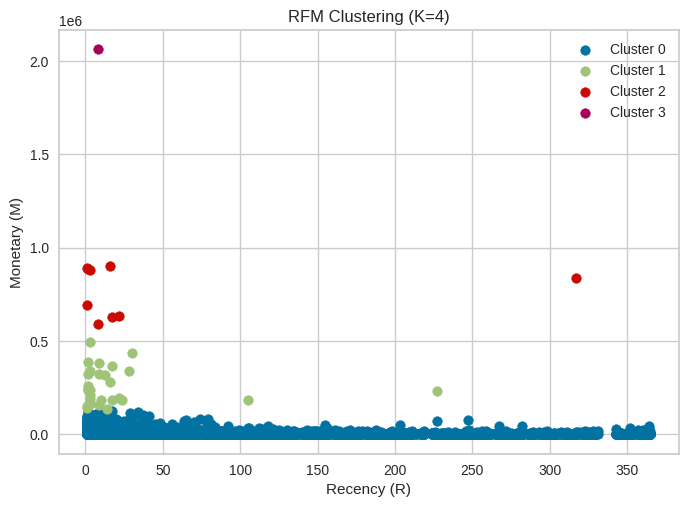

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Tạo dataframe chứa dữ liệu RFM
# Assume rfm_df là dataframe chứa dữ liệu RFM của khách hàng, với cột RFM là kết quả đã tính toán từ RFM analysis
rfm_df = rfm.copy()

# Áp dụng K-means với k=4
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=200)
kmeans.fit(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_df['Cluster'] = kmeans.labels_

# Biểu đồ phân tán
plt.scatter(rfm_df[rfm_df['Cluster'] == 0]['Recency'], rfm_df[rfm_df['Cluster'] == 0]['Monetary'], label='Cluster 0')
plt.scatter(rfm_df[rfm_df['Cluster'] == 1]['Recency'], rfm_df[rfm_df['Cluster'] == 1]['Monetary'], label='Cluster 1')
plt.scatter(rfm_df[rfm_df['Cluster'] == 2]['Recency'], rfm_df[rfm_df['Cluster'] == 2]['Monetary'], label='Cluster 2')
plt.scatter(rfm_df[rfm_df['Cluster'] == 3]['Recency'], rfm_df[rfm_df['Cluster'] == 3]['Monetary'], label='Cluster 3')
plt.xlabel('Recency (R)')
plt.ylabel('Monetary (M)')
plt.title('RFM Clustering (K=4)')
plt.legend()
plt.show()


<Figure size 700x700 with 0 Axes>

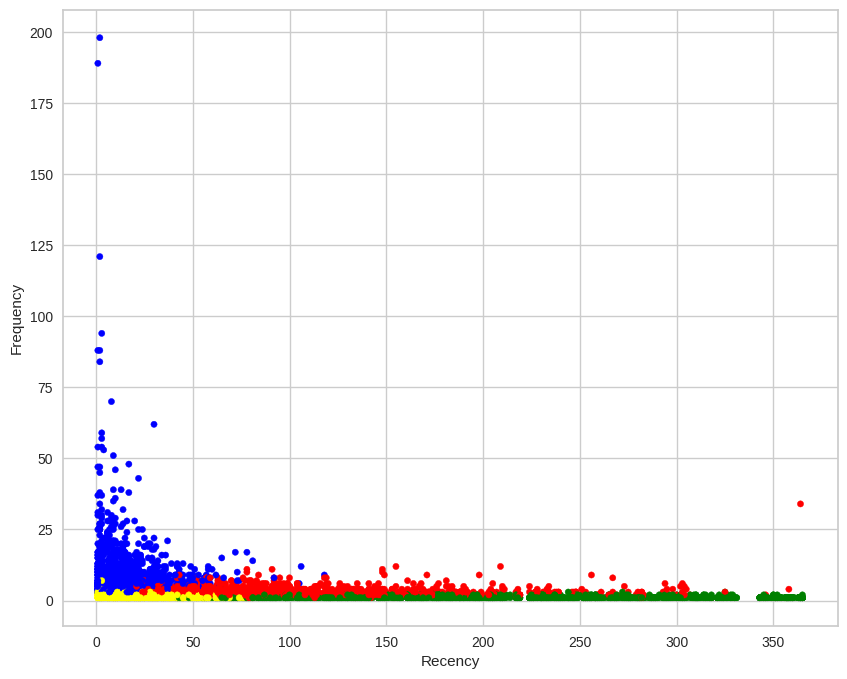

In [ ]:
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue", "yellow"]
rfm['Color'] = rfm['Cluster'].map(lambda p: Colors[p])
ax = rfm.plot(
    kind="scatter",
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = rfm['Color']
)

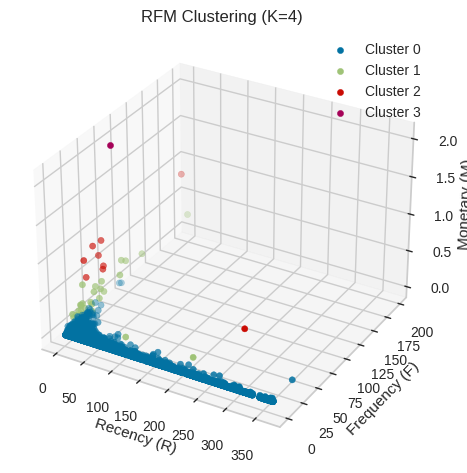

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.cluster import KMeans

# Tạo dataframe chứa dữ liệu RFM
# Assume rfm_df là dataframe chứa dữ liệu RFM của khách hàng, với cột RFM là kết quả đã tính toán từ RFM analysis

# Áp dụng K-means với k=4
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=200)
kmeans.fit(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_df['Cluster'] = kmeans.labels_

# Biểu đồ 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_df[rfm_df['Cluster'] == 0]['Recency'], rfm_df[rfm_df['Cluster'] == 0]['Frequency'], rfm_df[rfm_df['Cluster'] == 0]['Monetary'], label='Cluster 0')
ax.scatter(rfm_df[rfm_df['Cluster'] == 1]['Recency'], rfm_df[rfm_df['Cluster'] == 1]['Frequency'], rfm_df[rfm_df['Cluster'] == 1]['Monetary'], label='Cluster 1')
ax.scatter(rfm_df[rfm_df['Cluster'] == 2]['Recency'], rfm_df[rfm_df['Cluster'] == 2]['Frequency'], rfm_df[rfm_df['Cluster'] == 2]['Monetary'], label='Cluster 2')
ax.scatter(rfm_df[rfm_df['Cluster'] == 3]['Recency'], rfm_df[rfm_df['Cluster'] == 3]['Frequency'], rfm_df[rfm_df['Cluster'] == 3]['Monetary'], label='Cluster 3')
ax.set_xlabel('Recency (R)')
ax.set_ylabel('Frequency (F)')
ax.set_zlabel('Monetary (M)')
ax.set_title('RFM Clustering (K=4)')
ax.legend()
plt.show()


In [ ]:
rfm = rfm.assign(
    segt_name = lambda dataframe: dataframe['Cluster'].map(lambda cluster: 'A' if cluster == 0
                                                           else 'B' if cluster == 1
                                                           else 'C' if cluster == 2
                                                           else 'D')
)

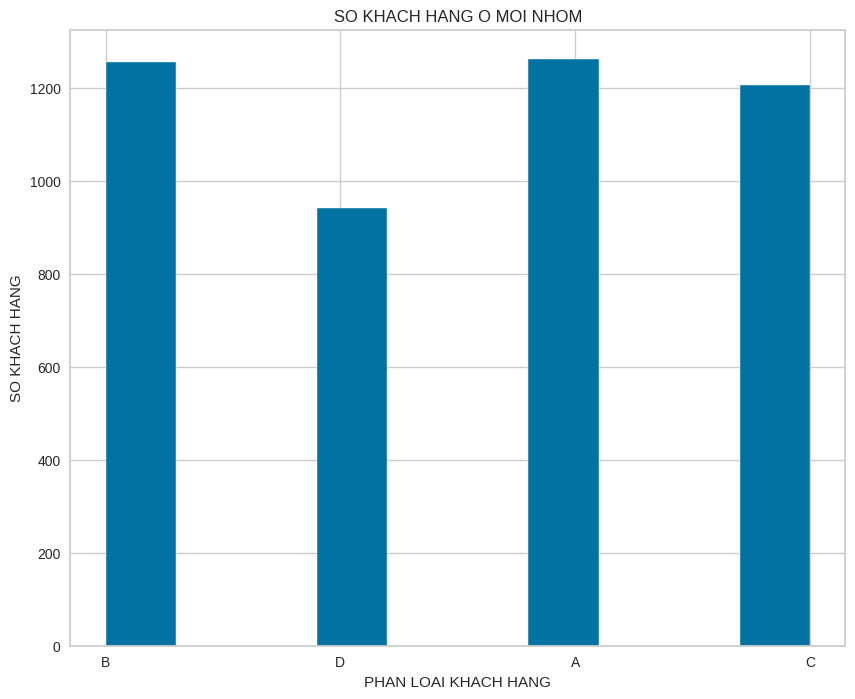

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(rfm['segt_name'])
plt.title('SO KHACH HANG O MOI NHOM')
plt.xlabel('PHAN LOAI KHACH HANG')
plt.ylabel('SO KHACH HANG')
plt.show()